In [1]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from afinn import Afinn
import pkg_resources

c:\Users\markham\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
test_data = pd.read_csv('data/processed_articles_2021_V1.csv')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data['content'] = test_data['content'].apply(lambda x: ' '.join(x.split(',')))
stop_words = set(stopwords.words('english'))
stop_words_list = [ 'msci','iran','states','italy','united','china','usa','us','america','american','americans','chinese','china','russia','russian','putin','vladimir','trump','donald','biden','joe','ukraine','ukrainian','ukrainians','ukraines','ukraine','say','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','mon','tue','wed','thu','fri','sat','sun','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january','february','march','april','may','june','july','august','september','october','november','december','today','yesterday','tomorrow','week','month','year','time','day','weekend','morning','afternoon','evening','night','news','new','news']
list_numbers = ['liga','len','nhl','one','two','three','four','five','six','seven','eight','nine','ten','hundred','thousand','million','billion','trillion','first','second','third']
country_list = ['China', 'United States of America', 'United Kingdom', 'France', 'Germany', 'Japan', 'Russia', 'Australia', 'Canada', 'India', 'Brazil', 'Italy', 'Spain', 'South Korea', 'Mexico', 'Netherlands', 'Switzerland', 'Sweden', 'Norway', 'Denmark', 'Finland', 'Greece', 'Ireland', 'Portugal', 'Poland', 'Ukraine', 'Romania', 'Belgium', 'Austria', 'Turkey', 'Saudi Arabia', 'United Arab Emirates', 'Iran', 'Iraq', 'Israel', 'Egypt', 'South Africa', 'Argentina', 'Venezuela', 'Thailand', 'Malaysia', 'Singapore', 'Indonesia', 'Philippines', 'Pakistan', 'Bangladesh', 'Nigeria', 'Kenya', 'Tanzania', 'Uganda']
stop_words.update(stop_words_list)
stop_words.update(list_numbers)
stop_words.update(country_list)
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word != 'nan']))
test_data['content_tokens'] = test_data['content'].apply(lambda x: x.split())
test_data

,date,content,content_tokens
146,2020-12-30,half measure mind gap nod vaccine raise questi...,"[half, measure, mind, gap, nod, vaccine, raise..."
2764,2020-12-31,man shot dead gunfire exchange policepolice sh...,"[man, shot, dead, gunfire, exchange, policepol..."
2749,2020-12-31,jobless claim dip show recovery long way gofew...,"[jobless, claim, dip, show, recovery, long, wa..."
2772,2020-12-31,former man utd scotland manager tommy docherty...,"[former, man, utd, scotland, manager, tommy, d..."
2777,2021-01-01,saint clear end isolation ahead liverpool clas...,"[saint, clear, end, isolation, ahead, liverpoo..."
...,...,...,...
2123,2021-01-31,hungarian protest lockdown measure gather banb...,"[hungarian, protest, lockdown, measure, gather..."
2124,2021-01-31,luna rossas spithill call ahead ineos showdown...,"[luna, rossas, spithill, call, ahead, ineos, s..."
2117,2021-01-31,egypt current account deficit widen julyseptca...,"[egypt, current, account, deficit, widen, july..."
2195,2021-01-31,gulf market low saudi arabia vaccine delaysaud...,"[gulf, market, low, saudi, arabia, vaccine, de..."


In [3]:
# Step 2: Train Word2Vec model on tokenized words
model = Word2Vec(sentences=test_data['content_tokens'], vector_size=100, window=6, min_count=2, workers=8)

# 初始化 VADER 分析器
sid = SentimentIntensityAnalyzer()

# 获取积极和消极词
positive_words = [word for word, score in sid.lexicon.items() if score > 1.5 and word.isalpha()]
negative_words = [word for word, score in sid.lexicon.items() if score < -1.5 and word.isalpha()]

positive_seed_words = [word for word in positive_words if word in model.wv]
negative_seed_words = [word for word in negative_words if word in model.wv]

if not positive_seed_words or not negative_seed_words:
    print("Warning: Some seed words are not in the model's vocabulary. Check vocabulary or data.")

# Step 4: Precompute TF-IDF weights for the vocabulary
corpus = test_data['content'].tolist()  # Use space-separated strings for TF-IDF
vectorizer = TfidfVectorizer(vocabulary=model.wv.index_to_key)
tfidf_matrix = vectorizer.fit_transform(corpus)
word2tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

# Step 5: Precompute similarity to seed words for efficiency
word_similarities = {}
for word in model.wv.index_to_key:
    pos_sim = max([model.wv.similarity(word, seed) for seed in positive_seed_words], default=0)
    neg_sim = max([model.wv.similarity(word, seed) for seed in negative_seed_words], default=0)
    word_similarities[word] = max(pos_sim, neg_sim)

# Step 6: Filter important words (top N most similar to seed words)
N = 10  # Select top 30 words per article; adjust as needed
test_data['important_words'] = test_data['content_tokens'].apply(
    lambda tokens: sorted(
        [token for token in tokens if token in word_similarities],
        key=lambda x: word_similarities[x],
        reverse=True
    )[:N]
)

# Step 7: Define a function to convert text to a weighted vector
def text_to_vector(text, model, word2tfidf):
    """Convert text to a weighted average vector using TF-IDF weights."""
    vectors = []
    weights = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
            weights.append(word2tfidf.get(word, 1.0))  # Default weight 1.0 if not in TF-IDF
    if not vectors:
        return np.zeros(model.vector_size)
    vectors = np.array(vectors)
    weights = np.array(weights) / sum(weights)  # Normalize weights
    return np.average(vectors, axis=0, weights=weights)

# Step 8: Convert important words to vectors
test_data['vector'] = test_data['important_words'].apply(lambda x: text_to_vector(x, model, word2tfidf))

# Step 9: Prepare data for clustering
X = np.array(test_data['vector'].tolist())

# Step 10: Perform clustering
num_clusters = 2  # Adjustable; you can experiment with different numbers
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)
test_data['cluster_label'] = labels

# Display the updated DataFrame
test_data

,date,content,content_tokens,important_words,vector,cluster_label
146,2020-12-30,half measure mind gap nod vaccine raise questi...,"[half, measure, mind, gap, nod, vaccine, raise...","[clear, best, easy, effective, successful, mer...","[-0.022843230738174458, 0.04156990999903648, -...",0
2764,2020-12-31,man shot dead gunfire exchange policepolice sh...,"[man, shot, dead, gunfire, exchange, policepol...","[felony, felony, dead, kill, kill, death, prot...","[-0.059465754125897816, -0.1901266661188693, -...",0
2749,2020-12-31,jobless claim dip show recovery long way gofew...,"[jobless, claim, dip, show, recovery, long, wa...","[clear, benefit, recession, progress, benefit,...","[-0.05325351897074475, 0.2239989192831609, -0....",0
2772,2020-12-31,former man utd scotland manager tommy docherty...,"[former, man, utd, scotland, manager, tommy, d...","[popularly, die, illness, sadden, attack, best...","[-0.07087234936755762, -0.08632174358612452, 0...",0
2777,2021-01-01,saint clear end isolation ahead liverpool clas...,"[saint, clear, end, isolation, ahead, liverpoo...","[clear, clear, clear, clear, isolation, confid...","[-0.0659008365410276, -0.18254326951547478, -0...",0
...,...,...,...,...,...,...
2123,2021-01-31,hungarian protest lockdown measure gather banb...,"[hungarian, protest, lockdown, measure, gather...","[threaten, death, ban, die, violate, protest, ...","[-0.05976219892777324, -0.008678403671277037, ...",0
2124,2021-01-31,luna rossas spithill call ahead ineos showdown...,"[luna, rossas, spithill, call, ahead, ineos, s...","[encourage, definitely, confident, fortunate, ...","[-0.11441596079752304, 0.026707777632329115, 0...",0
2117,2021-01-31,egypt current account deficit widen julyseptca...,"[egypt, current, account, deficit, widen, july...","[deficit, deficit, collapse, deficit, positive...","[-0.20562253496968091, 0.07746166172016564, 0....",0
2195,2021-01-31,gulf market low saudi arabia vaccine delaysaud...,"[gulf, market, low, saudi, arabia, vaccine, de...","[ban, profit, fight, ban, profit, bad, crisis,...","[-0.15906341975959407, 0.09009575470715257, -0...",0


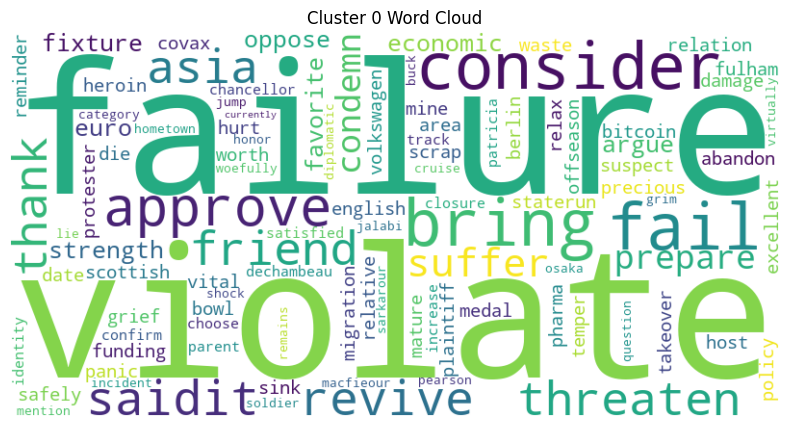

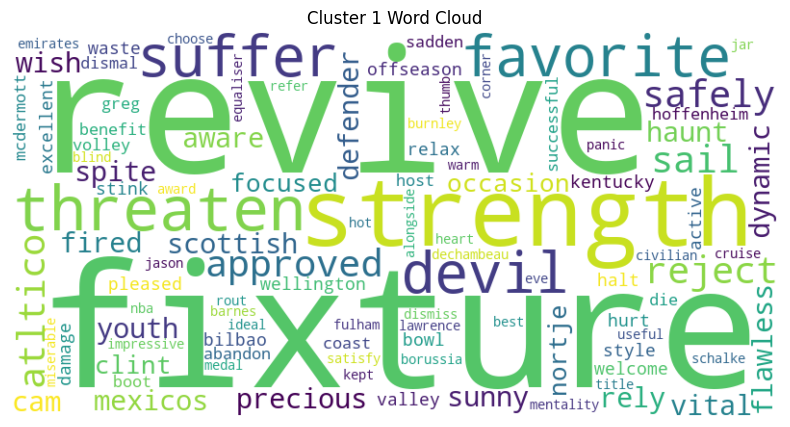

In [4]:
# Function to generate word cloud
def plot_word_cloud(text, title):
    """Generate and display a word cloud for the given text."""
    # Filter out stop words and non-alphabetic tokens
    words = ' '.join(word for word in text.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2)
    if not words.strip():
        print(f"No valid words for word cloud in {title}")
        return
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100, 
        min_font_size=10,
        stopwords=stop_words
    ).generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each cluster
for cluster in range(num_clusters):
    # Merge important_words for the cluster into a single string, removing duplicates
    cluster_words = set(word for item in test_data[test_data['cluster_label'] == cluster]['important_words'].dropna() for word in item)
    cluster_text = ' '.join(cluster_words)
    if cluster_text.strip():
        plot_word_cloud(cluster_text, f'Cluster {cluster} Word Cloud')
    else:
        print(f"No data for Cluster {cluster} Word Cloud")

In [5]:
# Evaluate clustering effect
if 'cluster_label' in test_data and len(set(test_data['cluster_label'])) > 1:
    X = np.array(test_data['vector'].tolist())  # Assuming 'vector' is from the Word2Vec/KMeans pipeline
    labels = test_data['cluster_label'].values
    
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {ch_score:.3f}")
else:
    print("Unable to calculate clustering metrics: Either no 'cluster_label' column or fewer than 2 clusters.")

Silhouette Score: 0.345
Calinski-Harabasz Index: 1191.681


In [6]:
# Use VADER to analyze sentiment of important words in each cluster
# Ensure date is in datetime format (already done in your preprocessing, but confirm)
test_data['date'] = pd.to_datetime(test_data['date'])

# Group by date
grouped = test_data.groupby('date')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Store daily sentiment results for each cluster
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []

        for important_words in cluster_data['important_words'].dropna():
            # Ensure important_words is a list; if it's a string, split it
            if isinstance(important_words, str):
                words = [word for word in important_words.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            elif isinstance(important_words, list):
                words = [word for word in important_words if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            else:
                continue  # Skip invalid data

            if not words:
                continue  # Skip if no valid words after filtering

            text = " ".join(words)

            try:
                # Calculate sentiment scores using VADER
                sentiment = analyzer.polarity_scores(text)
                compound_score = sentiment['compound']  # Primary sentiment score
                positive_score = sentiment['pos']
                negative_score = sentiment['neg']
                neutral_score = sentiment['neu']
                sentiment_scores.append({
                    'compound': compound_score,
                    'positive': positive_score,
                    'negative': negative_score,
                    'neutral': neutral_score
                })
            except Exception as e:
                print(f"Error processing text for date {date}, cluster {cluster}: {text[:50]}..., Error: {e}")
                continue

        # Calculate average sentiment scores
        if sentiment_scores:
            avg_sentiment = {
                'compound': np.mean([s['compound'] for s in sentiment_scores]),
                'positive': np.mean([s['positive'] for s in sentiment_scores]),
                'negative': np.mean([s['negative'] for s in sentiment_scores]),
                'neutral': np.mean([s['neutral'] for s in sentiment_scores])
            }
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': avg_sentiment['compound'],
                'positive_score': avg_sentiment['positive'],
                'negative_score': avg_sentiment['negative'],
                'neutral_score': avg_sentiment['neutral'],
                'num_samples': len(sentiment_scores)
            })
        else:
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': 0.0,
                'positive_score': 0.0,
                'negative_score': 0.0,
                'neutral_score': 0.0,
                'num_samples': 0
            })

# Create DataFrame from sentiment results
sentiment_df = pd.DataFrame(sentiment_results)

# Print results
print("\nSentiment Analysis Results:")
sentiment_df


Sentiment Analysis Results:


,date,cluster,sentiment_score,positive_score,negative_score,neutral_score,num_samples
0,2020-12-30,0,0.984900,1.000000,0.000000,0.000000,1
1,2020-12-30,1,0.000000,0.000000,0.000000,0.000000,0
2,2020-12-31,0,-0.243767,0.431000,0.569000,0.000000,3
3,2020-12-31,1,0.000000,0.000000,0.000000,0.000000,0
4,2021-01-01,0,0.309746,0.484362,0.283203,0.232464,69
...,...,...,...,...,...,...,...
61,2021-01-30,1,0.513453,0.599016,0.293891,0.107141,64
62,2021-01-31,0,0.041516,0.405898,0.348194,0.245963,108
63,2021-01-31,1,0.326527,0.526477,0.326523,0.147045,44
64,2021-02-03,0,0.778300,0.561000,0.263000,0.175000,1


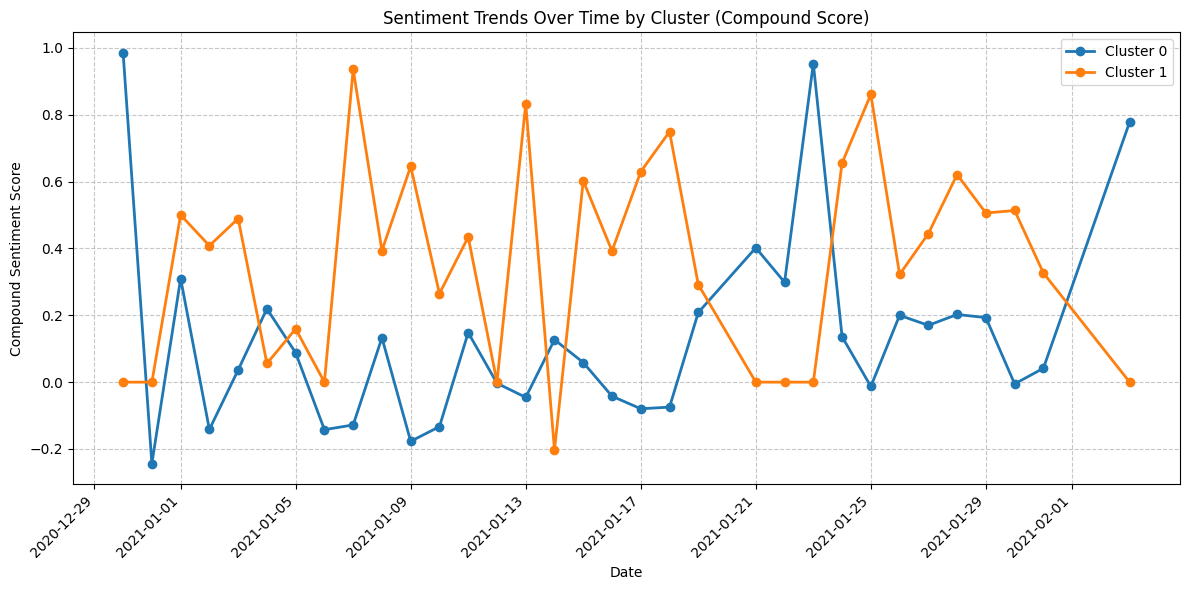

In [7]:
# Visualize sentiment scores over time for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = sentiment_df[sentiment_df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['sentiment_score'], label=f'Cluster {cluster}', marker='o', linestyle='-', linewidth=2)

plt.title('Sentiment Trends Over Time by Cluster (Compound Score)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
# Use FinBERT for sentiment analysis
# Ensure date is in datetime format
test_data['date'] = pd.to_datetime(test_data['date'])

# Group by date
grouped = test_data.groupby('date')

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"  # FinBERT model fine-tuned for financial sentiment
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline with FinBERT
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True  # Return probabilities for all labels
)

# Function to process text and get FinBERT sentiment
def get_finbert_sentiment(text, max_length=512):
    """Get sentiment scores using FinBERT, handling text truncation if necessary."""
    if not text or not isinstance(text, str):
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 0.0}
    
    # Truncate text if longer than max_length to avoid errors
    if len(text.split()) > max_length:
        text = " ".join(text.split()[:max_length])
    
    try:
        result = sentiment_analyzer(text)[0]  # Get the first (and only) result
        scores = {item['label'].lower(): item['score'] for item in result}
        # Ensure all labels (positive, negative, neutral) are present
        return {
            'positive': scores.get('positive', 0.0),
            'negative': scores.get('negative', 0.0),
            'neutral': scores.get('neutral', 0.0)
        }
    except Exception as e:
        print(f"Error processing text with FinBERT: {text[:50]}..., Error: {e}")
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 0.0}

# Store daily sentiment results for each cluster
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []

        for important_words in cluster_data['important_words'].dropna():
            # Ensure important_words is a list; if it's a string, split it
            if isinstance(important_words, str):
                words = [word for word in important_words.split() if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            elif isinstance(important_words, list):
                words = [word for word in important_words if word.lower() not in stop_words and word.isalpha() and len(word) > 2]
            else:
                continue  # Skip invalid data

            if not words:
                continue  # Skip if no valid words after filtering

            text = " ".join(words)

            # Get sentiment scores using FinBERT
            sentiment = get_finbert_sentiment(text)
            sentiment_scores.append(sentiment)

        # Calculate average sentiment scores
        if sentiment_scores:
            avg_sentiment = {
                'positive': np.mean([s['positive'] for s in sentiment_scores]),
                'negative': np.mean([s['negative'] for s in sentiment_scores]),
                'neutral': np.mean([s['neutral'] for s in sentiment_scores])
            }
            # Calculate a compound-like score (e.g., positive - negative)
            compound_score = avg_sentiment['positive'] - avg_sentiment['negative']
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': compound_score,  # Use positive - negative as compound score
                'positive_score': avg_sentiment['positive'],
                'negative_score': avg_sentiment['negative'],
                'neutral_score': avg_sentiment['neutral'],
                'num_samples': len(sentiment_scores)
            })
        else:
            sentiment_results.append({
                'date': date,
                'cluster': cluster,
                'sentiment_score': 0.0,
                'positive_score': 0.0,
                'negative_score': 0.0,
                'neutral_score': 0.0,
                'num_samples': 0
            })

# Create DataFrame from sentiment results
sentiment_df = pd.DataFrame(sentiment_results)

# Print results
print("\nSentiment Analysis Results (FinBERT):")
print(sentiment_df)

Device set to use cpu
c:\Users\markham\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



Sentiment Analysis Results (FinBERT):
         date  cluster  sentiment_score  positive_score  negative_score  \
0  2020-12-30        0         0.999999        0.999999    5.074921e-07   
1  2020-12-30        1         0.000000        0.000000    0.000000e+00   
2  2020-12-31        0         0.340804        0.356483    1.567915e-02   
3  2020-12-31        1         0.000000        0.000000    0.000000e+00   
4  2021-01-01        0         0.300069        0.407205    1.071352e-01   
..        ...      ...              ...             ...             ...   
61 2021-01-30        1         0.667237        0.700059    3.282249e-02   
62 2021-01-31        0         0.166679        0.301867    1.351878e-01   
63 2021-01-31        1         0.430000        0.529804    9.980417e-02   
64 2021-02-03        0        -0.111715        0.000834    1.125496e-01   
65 2021-02-03        1         0.000000        0.000000    0.000000e+00   

    neutral_score  num_samples  
0    3.231888e-07          

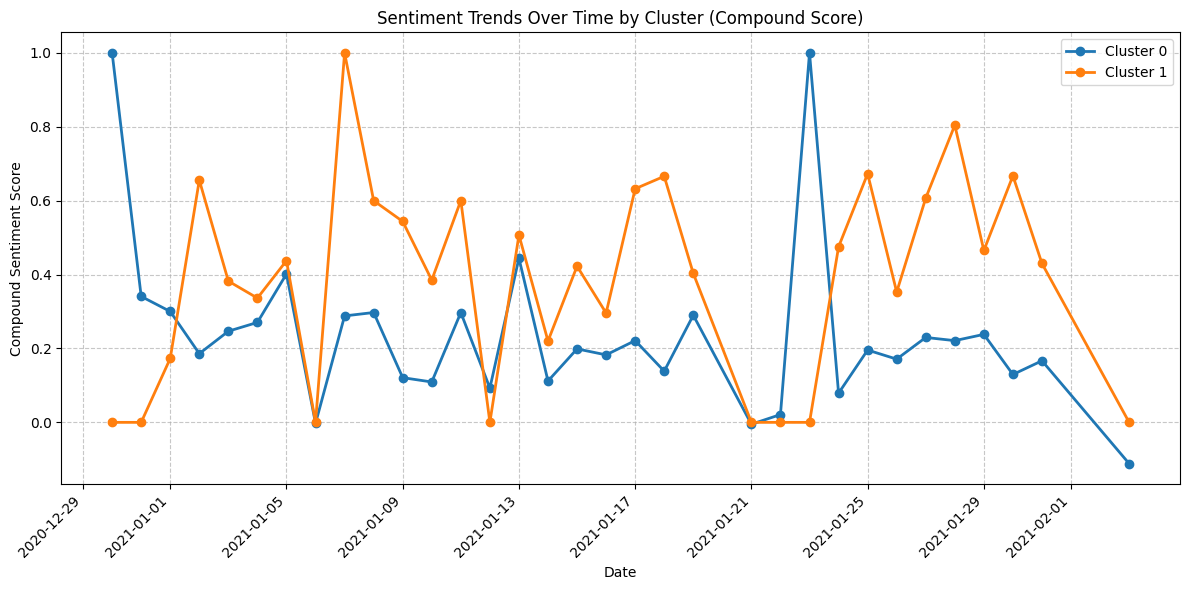

In [9]:
# Visualize sentiment scores over time for each cluster
plt.figure(figsize=(12, 6))
for cluster in range(num_clusters):
    cluster_data = sentiment_df[sentiment_df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['sentiment_score'], label=f'Cluster {cluster}', marker='o', linestyle='-', linewidth=2)

plt.title('Sentiment Trends Over Time by Cluster (Compound Score)')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()